In [1]:
import ThinFilmDataCreation as tfdc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.decomposition import NMF
import dask
import glob as glob
from tifffile import imread, imshow
import warnings
import dask

def attempt(Real_Data, Length, i, init= None, solver = 'cd', beta_loss = 'frobenius', iter = 500):
    NMF_model = NMF(n_components=i, init = init, solver = solver, beta_loss = beta_loss, max_iter = iter)
    NMF_data= NMF_model.fit_transform(Real_Data)
    fit_compos = NMF_model.components_
    Q = np.array(NMF_model.reconstruction_err_)*100
    warnings.filterwarnings("ignore", category=FutureWarning)
    return Q

def attempt2(Real_Data, Length, i, init= None, solver = 'cd', beta_loss = 'frobenius', iter = 500):
    NMF_model = NMF(n_components=i, init = init, solver = solver, beta_loss = beta_loss, max_iter = iter)
    NMF_data= NMF_model.fit_transform(Real_Data)
    fit_compos = NMF_model.components_
    Q = np.array(NMF_model.reconstruction_err_)*100
    warnings.filterwarnings("ignore", category=FutureWarning)
    return Q, fit_compos, NMF_data


def Run_NMF(Real_Data, init= None, solver = 'cd', beta_loss = 'frobenius', itear = 1000, show = False):
    
    """" Comparison of multiple components without manually comparing
    multiple components all at once. There are a few ways that this can be done. One way
    is to take the residuals of the datasets with themselves to see which is the closests to the 
    "correct" component. This may only be done on sample data potentially. Could include a 
    simulated dataset of what the standing component should look like give or take some 
    variations in the data. When the residuals are taken if it is less than some given 
    percentage the would be the dataset/NMF component to use further. There may be multiple
    thus having to go in manually to find differences. 
    
    To do this, will need to import the simulated XRD pattern from VESTA and then take the residual differences
    of each component and compared to the simulated pattern. Will have the program spit out the compnents that
    meet the cutoff. """

    In = init
    Solve = solver
    Beta = beta_loss
    It = itear
    

    jobs = [dask.delayed(attempt)(Real_Data, Real_Data.shape[1], i, In, Solve, Beta, It) for i in range(1, Real_Data.shape[1])]
    #jobs = [dask.delayed(attempt)(Real_Data, Real_Data.shape[1], i, In, Solve, Beta, It) for i in range(1,20)]
    calcs = dask.compute(jobs)[0]

    calcs = np.array(calcs)
    min_Q = np.min(calcs)
    noc = np.where(calcs == min_Q)
    noc_2 = noc[0]
    number_of_components = noc_2[0] +1

    Divergence, compos, NMF_Data_2 = attempt2(Real_Data, Real_Data.shape[1], number_of_components, In, Solve, Beta)
            
    
    print('The beta-divergence is: ', Divergence, '%\n','The final number of components used were',number_of_components+1, '\n') 
    
    
    m = pd.DataFrame(compos)
    m = m.T
    
    if show == True:
        plt.figure(figsize = (5,5))
        colors = plt.cm.magma(np.linspace(0,1, number_of_components))
        i = 0
        while i < number_of_components:
            plt.plot(m[i], c = colors[i], alpha = 0.7)
            i = i+1
    
    return m,NMF_Data_2, min_Q

def AggCluster(Number_Clusters, data):
    
    """A program that will take in the type of scikitlearn clustering algorithm
        desired and the number of clusters as well as the data in a numpy array
        and output the associated clusters with the original data. This will make
        the 'latent' space from the clustering algorithms have more meaning"""

    from sklearn.cluster import AgglomerativeClustering
    Make_Clusters= AgglomerativeClustering(n_clusters = Number_Clusters, compute_distances=True)
    y_kmeans = Make_Clusters.fit_predict(data)
    information = Make_Clusters.fit(data)
    parameter = information.distances_

    x = 0
    Understanding_data = {"Cluster_Number":[], "Int_Angle":[]};
    while x < len(data):
        Understanding_data["Cluster_Number"].append(y_kmeans[x])
        Understanding_data["Int_Angle"].append(data[x])
        x = x+1
        
    # Create an empty list to store the data
    data_list = []
    
        
    q = 0
    while q < Number_Clusters:
        z = 0
        plt.figure(figsize=(5,5))
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Agglomerative Clustering'+' ' +str(q))

        while z < len(data):
            if Understanding_data["Cluster_Number"][z] == q:
                plt.plot(Understanding_data["Int_Angle"][z], label = 'Component'+str(z))
            z = z+1
    
        # Check if the plot looks good if the plot looks good, append the data to the list
        plt.show(block = False)
        plt.pause(0.1)
        
        if input("Do the identified components look like an isotropic scattering signal? (y/n)") == 'y':
            i = 0
            while i < len(data):
                if Understanding_data["Cluster_Number"][i] == q:
                    data_list.append(Understanding_data["Int_Angle"][i])
                i = i+1
                
        q = q+1
    
    return Understanding_data, data_list


def smooth_components(Identified_components, filter_strength = 2, show = False):
    '''A function that will smooth the components identified from the agglomerative clustering algorithm'''
    
    # Importing required library
    from scipy.signal import savgol_filter
    
    # Defining a dictionary that maps filter strength to the number of points for the smoothing window
    strength_to_points = {1: 3, 2: 5, 3: 7, 4: 11, 5: 15}
    
    # Retrieving the number of points for the smoothing window based on the filter strength provided
    points = strength_to_points.get(filter_strength)

    # Applying Savitzky-Golay filter to smooth the identified components by taking their average along the columns
    smoothed_compos = savgol_filter(np.mean(Identified_components, axis = 0), points, 1)
    
    # If show argument is True, plotting the original components, their average, and the smoothed components
    if show == True:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
        ax1.plot(Identified_components.T, c = 'k', linewidth = 2, alpha = 0.7)
        ax1.set_title('Identified Components')
        ax1.set_ylabel('Intensity')
        ax2.plot(np.mean(Identified_components, axis = 0), c = 'r', linewidth = 2, alpha = 0.7)
        ax2.set_ylabel('Intensity')
        ax2.set_title('Mean of Identified Components')
        ax3.plot(smoothed_compos, c = 'g', linewidth = 2, alpha = 0.7, label = 'Smoothed Component')
        ax3.scatter(np.arange(len(np.mean(Identified_components, axis = 0))), np.mean(Identified_components, axis = 0), c = 'r', s = 10, 
                    label = 'Mean Component')
        ax3.set_xlabel('Data Points')
        ax3.set_title('Smoothed Component')
        ax3.set_ylabel('Intensity')
        ax3.legend()
    
    # Returning the smoothed components
    return smoothed_compos

def run_nmfac(Data, initialize_iter = 0, clusters = 5):
    """A function that will run the NMF algorithm and then cluster with agglomerative clustering the components and returns the 
        identified components for later PDF analysis. The function starts with a random initializer
        that will be used to initialize the NMF algorithm. The user can decide how many iterations the 
        initializer takes. Then it will go through the NMF algorithm and compare the beta divergences of all the
        initializations and select the one with the lowest. By default, there is no initializer and the NMF algorithm
        uses preset parameters to run the algorithm. """
        
        #NMF Parameter Values
        
    import warnings
    warnings.filterwarnings("ignore")
    
    
    init_params = ['random', 'nndsvd', 'nndsvda', 'nndsvdar']
    solver_params = ['cd', 'mu']
    beta_loss_params = ['frobenius', 'kullback-leibler']
    tol_params = np.arange(0.00001, 0.01, 0.0001)
    max_iter_params = np.arange(100, 10000, 100)
    shuffle_params = [True, False]
        
    #When random initializers are not wanted
    if initialize_iter == 0:
        weights, components, beta = Run_NMF(Data, show = True)
        AggComponents = np.array(components).T
        AggClusters, found_compos = AggCluster(clusters, AggComponents)
        
        found_compos = np.array(found_compos)
        
    elif initialize_iter > 0:
        beta_div = []
        
        init_for_init = np.random.choice(init_params,initialize_iter)
        solver_for_init = np.random.choice(solver_params, initialize_iter)
        beta_loss_for_init = np.random.choice(beta_loss_params, initialize_iter)
        tol_for_init = np.random.choice(tol_params, initialize_iter)
        max_iter_for_init = np.random.choice(max_iter_params, initialize_iter)
        shuffle_for_init = np.random.choice(shuffle_params, initialize_iter)
        
        for i in range(initialize_iter):
            
            if beta_loss_for_init[i] == 'kullback-leibler':
                solver_for_init[i] = 'mu'
                
            print('The parameters selected for run' + str([i]) + ' are ' + str(init_for_init[i]) + ', ' + str(solver_for_init[i]) + ', ' + str(beta_loss_for_init[i]) + ', ' + str(tol_for_init[i]) + ', ' + str(max_iter_for_init[i]) + ', ' + str(shuffle_for_init[i]) + '. \n' )
            weights, components, beta = Run_NMF(Data, init = init_for_init[i], solver = solver_for_init[i], 
                                                beta_loss = beta_loss_for_init[i], itear = max_iter_for_init[i], show = False)
            
            beta_div.append(beta)
        beta_np = np.array(beta_div)
        good_init = np.argmin(beta_np)
        
        weights, components, beta = Run_NMF(Data, show = True, init = init_for_init[good_init], solver = solver_for_init[good_init], beta_loss=beta_loss_for_init[good_init],
                                             itear = max_iter_for_init[good_init])
        
        AggComponents = np.array(components).T
        AggClusters, found_compos = AggCluster(clusters, AggComponents)
        
        found_compos = np.array(found_compos)
            
        
    return found_compos, weights, components

In [2]:
import ThinFilmDataCreation as tfdc

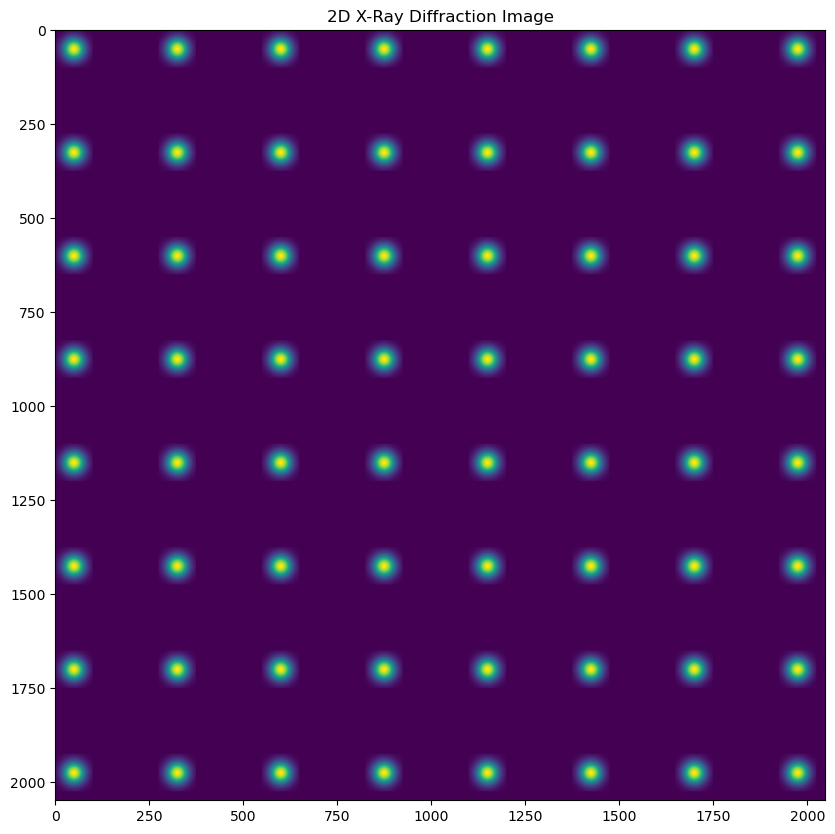

Select calibrant:
1. AgBh
2. Al
3. alpha_Al2O3
4. Au
5. C14H30O
6. CeO2
7. Cr2O3
8. cristobaltite
9. CrOx
10. CuO
11. hydrocerussite
12. LaB6
13. LaB6_SRM660a
14. LaB6_SRM660b
15. LaB6_SRM660c
16. mock
17. NaCl
18. Ni
19. PBBA
20. Pt
21. quartz
22. Si
23. Si_SRM640
24. Si_SRM640a
25. Si_SRM640b
26. Si_SRM640c
27. Si_SRM640d
28. Si_SRM640e
29. TiO2
30. ZnO
CuO


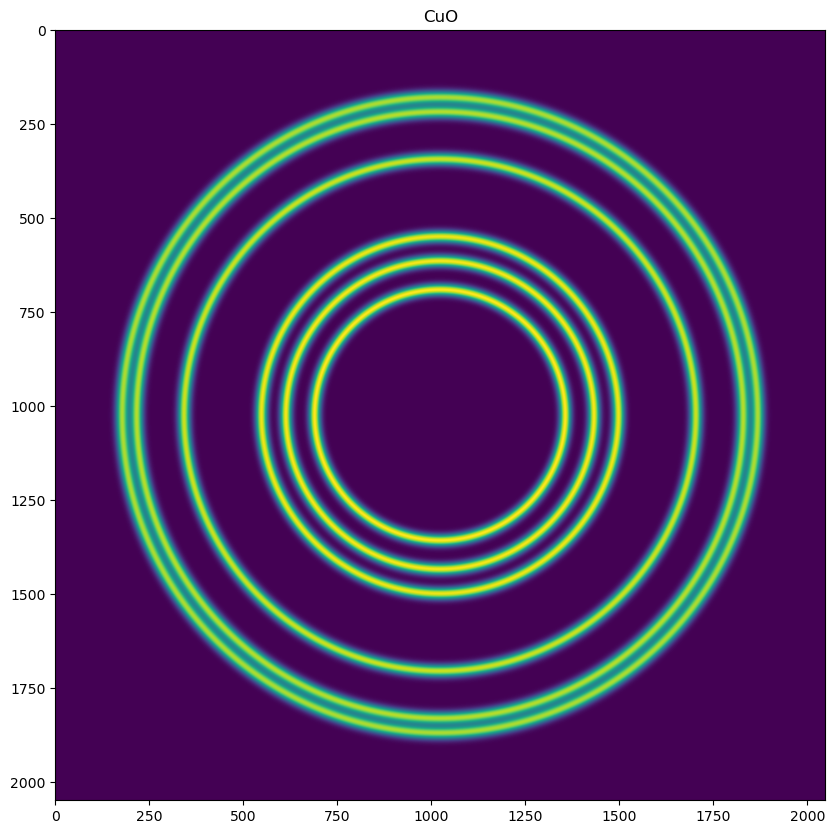

In [19]:
a = tfdc.create_anisotropic(10, 20, 275, 100)
b = tfdc.create_isotropic(.5, .4e-10, cmap = 'viridis')


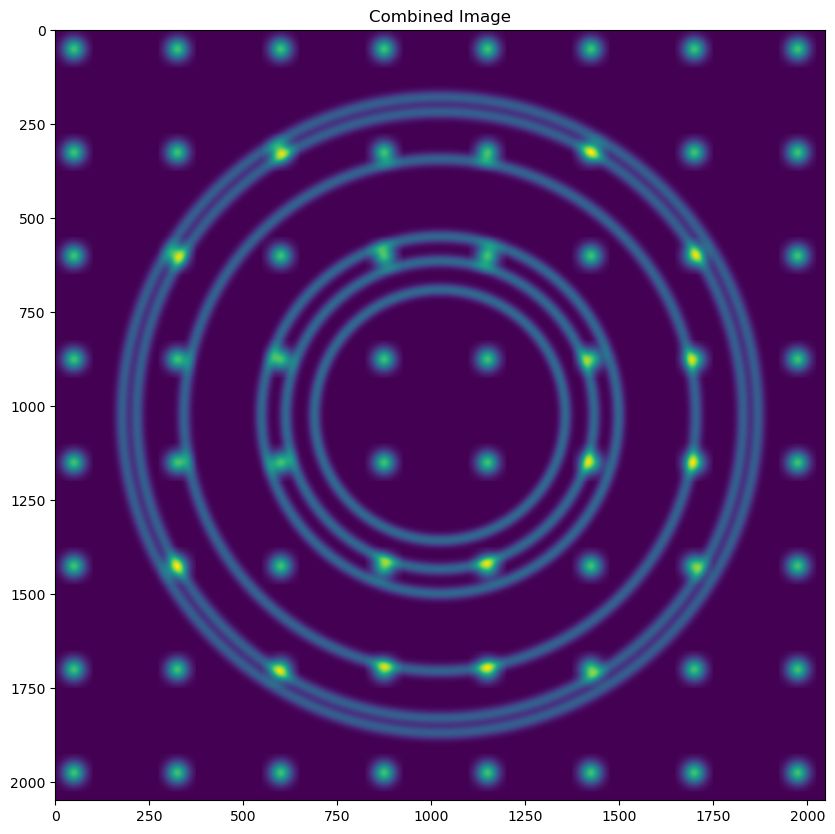

In [21]:
c = tfdc.combine_image(a*2,b)

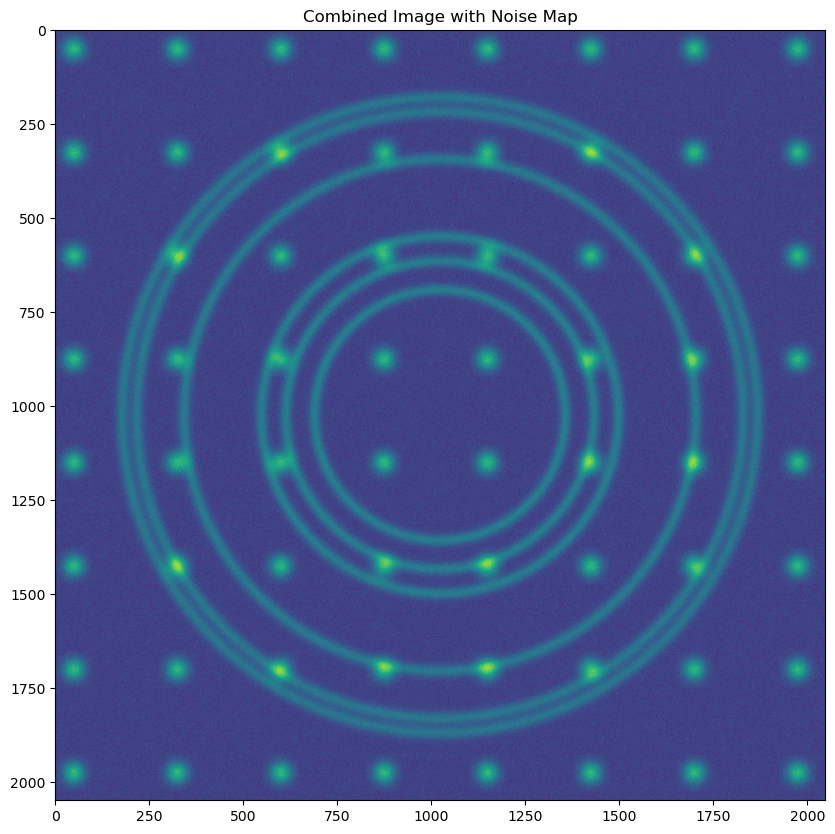

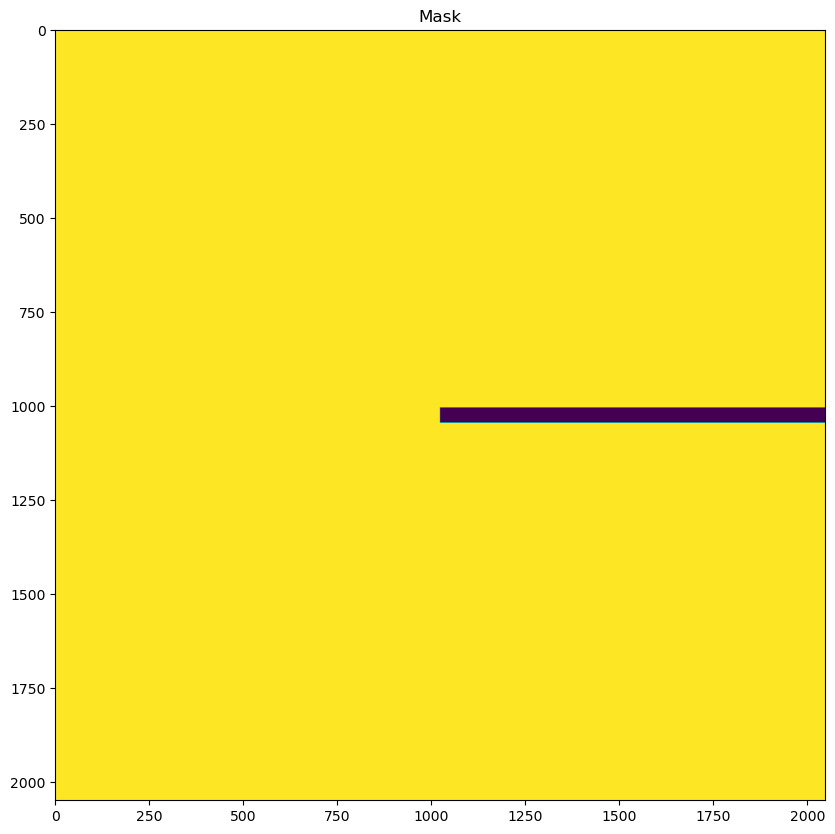

In [33]:
c = tfdc.generate_noisemap(c, 0.35)
mask = tfdc.create_mask(c, 20)

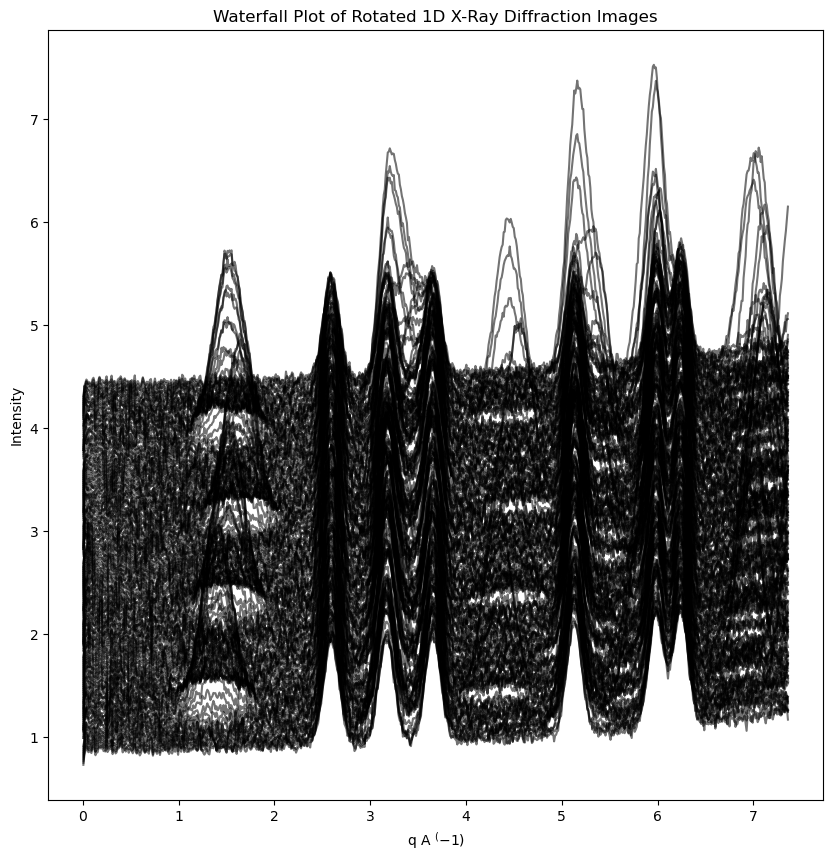

In [34]:
q, rot_data = tfdc.rotate_and_integrate(c, 2, .4, .4e-10, 700, mask =mask)

The parameters selected for run[0] are nndsvd, cd, frobenius, 0.0046099999999999995, 2100, True. 

The beta-divergence is:  61.92820775514058 %
 The final number of components used were 180 

The parameters selected for run[1] are random, mu, kullback-leibler, 0.00141, 3400, False. 

The beta-divergence is:  670.782320282529 %
 The final number of components used were 179 

The parameters selected for run[2] are nndsvda, cd, frobenius, 0.0009100000000000001, 9700, True. 

The beta-divergence is:  363.22233645281534 %
 The final number of components used were 159 

The parameters selected for run[3] are nndsvdar, mu, frobenius, 0.00301, 4400, False. 

The beta-divergence is:  602.8587267421611 %
 The final number of components used were 180 

The parameters selected for run[4] are random, mu, kullback-leibler, 0.00721, 2700, False. 

The beta-divergence is:  667.4664023869889 %
 The final number of components used were 180 

The parameters selected for run[5] are nndsvd, mu, frobenius, 

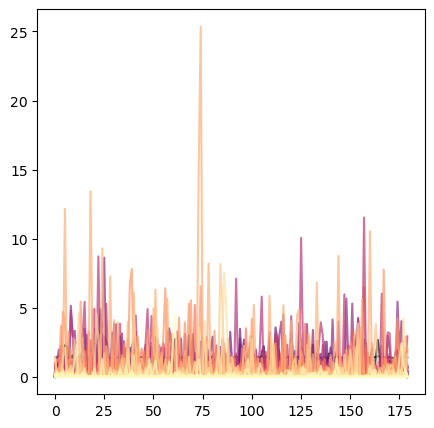

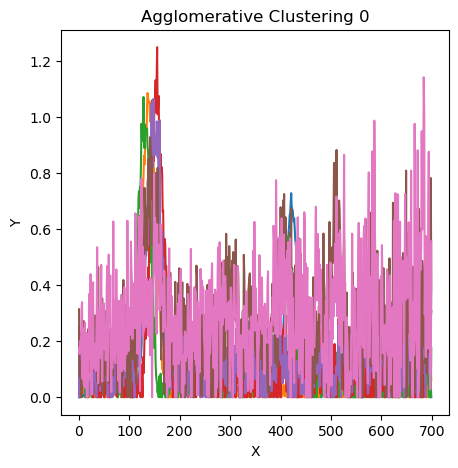

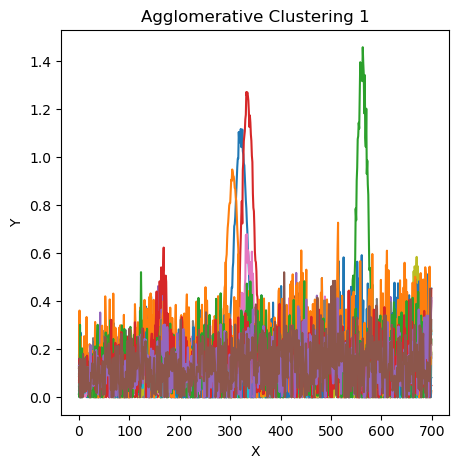

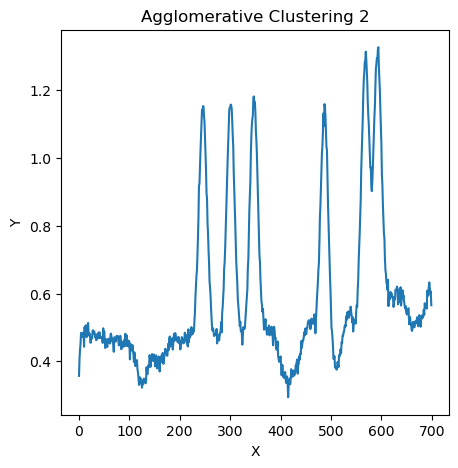

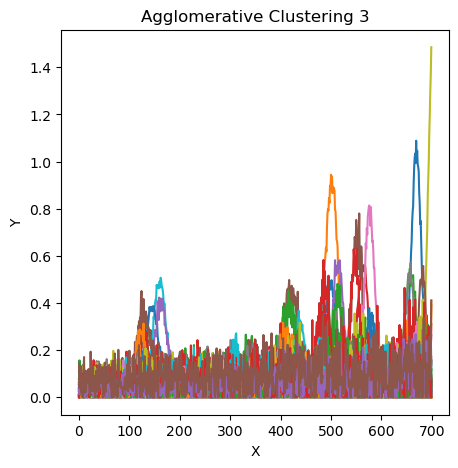

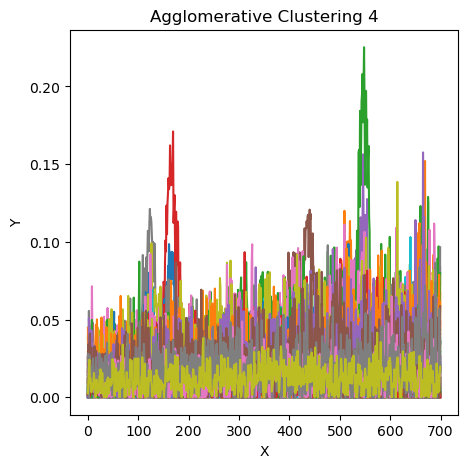

In [54]:
identified_comps, weights, components = run_nmfac(rot_data, initialize_iter = 10, clusters = 5)

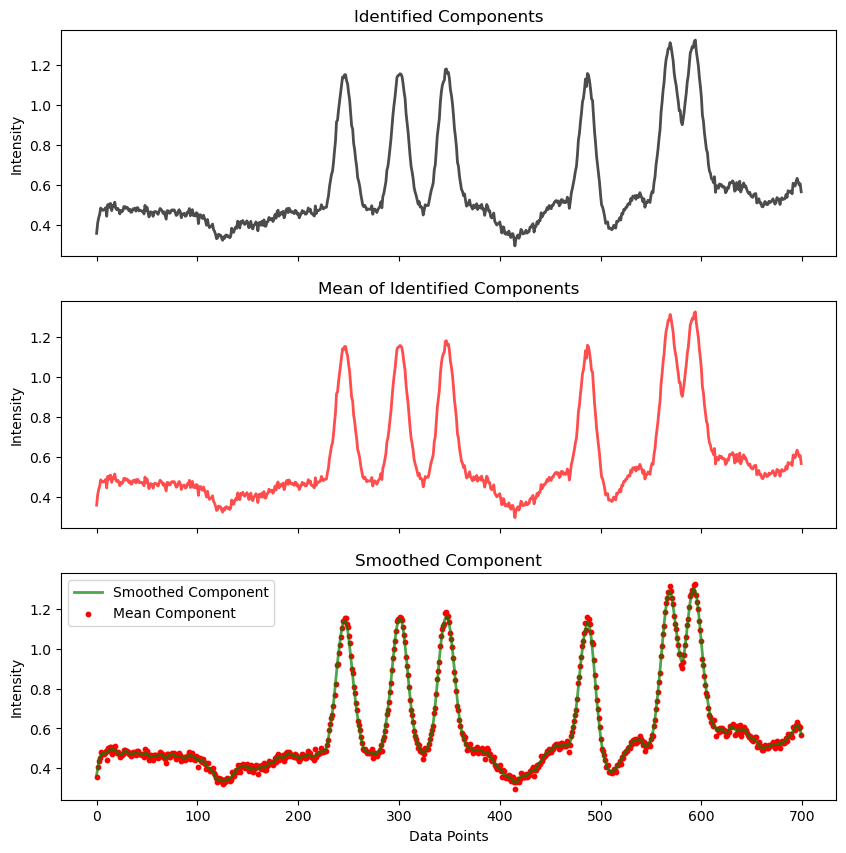

In [58]:
comps = smooth_components(identified_comps, 2, show = True)

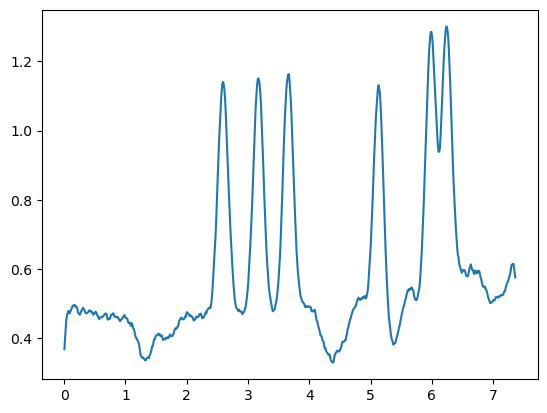

In [59]:
plt.plot(q, comps)

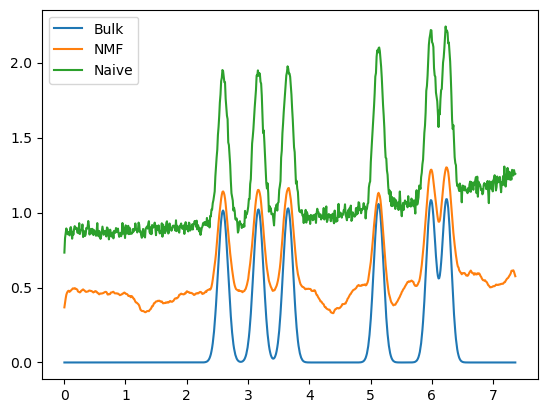

In [64]:
q1, bulk = tfdc.integrate_image(b, .4, .4e-10, 700, mask = mask)
q2, sc = tfdc.integrate_image(c, .4, .4e-10, 700, mask = mask)


plt.plot(q, bulk, label = 'Bulk')
plt.plot(q, comps, label = 'NMF')
plt.plot(q, sc, label = 'Naive')

plt.legend()

In [70]:
weights

,0,1,2,3,4,5,6,7,8,9,...,169,170,171,172,173,174,175,176,177,178
0,1.418820,0.000000,0.071058,0.027926,0.088143,0.020682,0.070760,0.043286,0.095716,0.038299,...,0.000000,0.0374,0.046551,0.000000,0.228290,0.000000,0.000000,0.149633,0.000000,0.000000
1,1.398466,0.000000,0.069313,0.015047,0.114117,0.029396,0.000000,0.017066,0.000000,0.070893,...,0.000000,0.0000,0.000000,0.000000,0.180521,0.000000,0.065425,0.000000,0.363208,0.000000
2,1.406050,0.000227,0.124536,0.016377,0.048518,0.155453,0.034650,0.041218,0.000000,0.047025,...,0.000000,0.0000,0.000000,0.000000,0.070273,0.000000,0.000000,0.256620,0.000000,0.000000
3,1.383393,0.000000,0.684970,0.016136,0.000000,0.431851,0.000000,0.061458,0.000000,0.019129,...,0.000000,0.0000,0.000000,0.249688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.342215,0.015358,1.599487,0.000000,0.009490,0.432768,0.004744,0.069306,0.000000,0.065512,...,0.000000,0.0000,0.018546,0.000000,0.222196,0.133546,0.078793,0.000000,0.411407,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.358873,0.000000,1.381393,0.019166,0.304615,0.431226,0.088103,0.065015,0.000000,0.001821,...,0.026097,0.0000,0.014420,0.000000,0.000000,0.000000,0.104586,0.000000,1.264750,0.007478
176,1.304836,0.019338,0.914791,0.000000,0.000000,0.551856,0.092949,0.032527,0.000211,0.000000,...,0.000000,0.0000,0.000000,0.011710,0.000000,0.000000,0.000000,0.000523,2.411730,0.000000
177,1.410094,0.024930,0.223184,0.017671,0.081591,0.045833,0.000000,0.015436,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.003770,0.000000,0.852172,0.007926
178,1.392062,0.012268,0.126217,0.000435,0.055630,0.000000,0.064257,0.075710,0.000000,0.000000,...,0.123095,0.0000,0.000000,0.000000,0.000000,0.000000,0.503377,0.052668,0.430627,0.000000


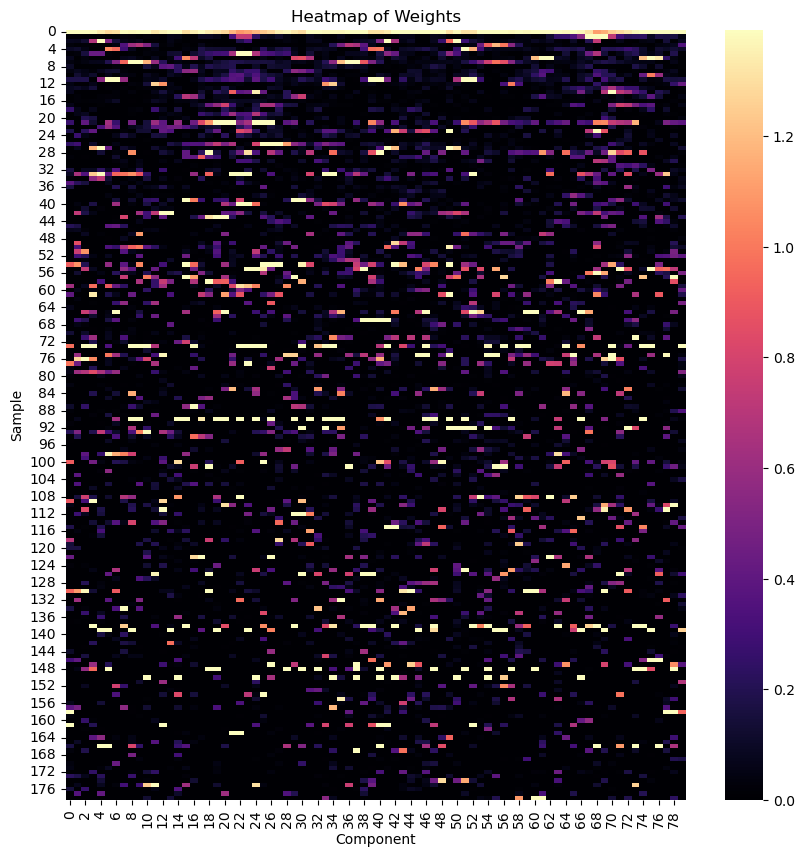

In [100]:
# Create the heat map of the weights but I would like the x-axis to be labeled with each component 
#and maybe have a space between each component

import seaborn as sns

def create_heatmap(weights, components):
    plt.figure(figsize = (10,10))
    sns.heatmap(weights.T, cmap = 'magma', robust = True)
    plt.xlabel('Component')
    plt.ylabel('Sample')
    plt.title('Heatmap of Weights')
    plt.show()
    
    
create_heatmap(weights[:80], components)

In [55]:
#I need to generate a spots on a 2048x2048 grid of zeros
#these spots should have the flexibility to be big or small and they should
#have the highest values in the center and then gaussianly distribute the values
#outwards from the center of the spot. These spots should also start at the 
#center of the image, 0,0 and then distribute in outwards in lines.
#The width of distribution of these spots can be varied but must start at the center


def generate_spots(size, num_spots, max_val, min_val, width):
    
    spot_grid = np.zeros((size, size))
    
    spot_grid[size//2, size//2] = max_val
    
    for i in range(num_spots):
        spot_grid[size//2, size//2 + i] = max_val - (max_val - min_val)*np.exp(-((i - size//2)**2)/(2*width**2))
        spot_grid[size//2, size//2 - i] = max_val - (max_val - min_val)*np.exp(-((i - size//2)**2)/(2*width**2))
        
    return spot_grid

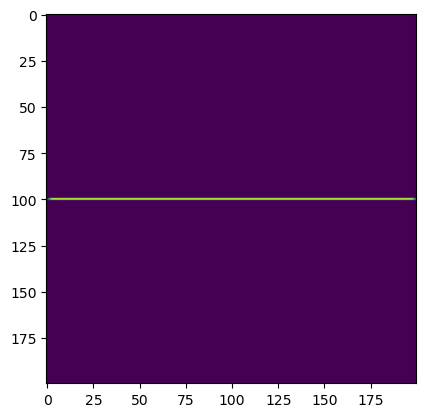

In [99]:
p = generate_spots(200, 100, 2000, 1, 1)

plt.imshow(p, cmap='viridis')

In [ ]:
def create_anisotropic(nspots, width, offset, size=4, shape = 'square', cmap = 'viridis'):
    """
    This function generates a 2D image of small spots on a detector image that's 2048x2048 pixels. Each spot is separated by a width and offset and has the highest intensity in the center of the spot and the 
    lowest intensity at the edges of the spot. The spots are 4x4 pixels in size. The function should take the number of spots, the width of the spots, and the offset between spots as parameters.

    Parameters:
        nspots (int): The number of spots to generate.
        width (float): The width of the spots.
        offset (float): The offset between spots.
    """
    # initialize the detector image
    detector_image = np.zeros((2048, 2048))
    
    
    

In [108]:
    #generate the spot where the highest intensity is in the center of the spot and the lowest intensity is at the edges of the spot, the intensity values are specified by the user as a parameter
    #the spots at a higher intensity at the center of the image and a lower intensity at the edges of the image but still have a gaussian distribution within the spot. 
    #the spots can either be square or cricular in shape and this is specified by the user, the default is square. This will start as a for loop.
    #these spots should be distributed starting at the center of the image and then moving outwards in lines. The number of spots and the width of the spots should be specified by the user as parameters.
    
    def generate_spots(size, num_spots, max_val, min_val, width):
    
        spot_grid = np.zeros((size, size))
    
        spot_grid[size//2, size//2] = max_val
    
        for i in range(num_spots):
            spot_grid[size//2, size//2 + i] = max_val - (max_val - min_val)*np.exp(-((i - size//2)**2)/(2*width**2))
            spot_grid[size//2, size//2 - i] = max_val - (max_val - min_val)*np.exp(-((i - size//2)**2)/(2*width**2))
            
        plt.imshow(spot_grid, cmap = 'viridis', vmin = 0, vmax = 100)
        
        return spot_grid

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

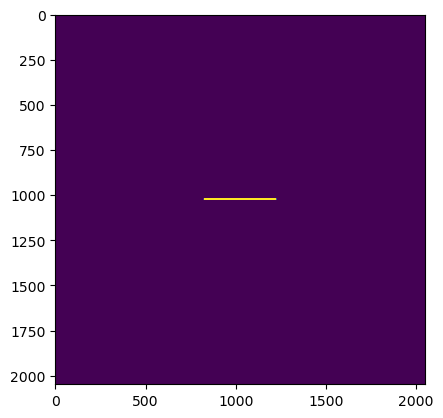

In [110]:
generate_spots(2048, 200, 2000, 1, 200)

In [111]:
import numpy as np
import matplotlib.pyplot as plt


def generate_spots(grid_size, spot_size, spot_intensity):
    # Define grid size
    grid_size = 2048

    # Define spot size and intensity
    spot_size = 100
    spot_intensity = 10000

    # Create grid of zeros
    grid = np.zeros((grid_size, grid_size))

    # Calculate center coordinates
    center_x = int(grid_size / 2)
    center_y = int(grid_size / 2)

    # Generate spot at center
    for i in range(center_x - int(spot_size/2), center_x + int(spot_size/2)):
        for j in range(center_y - int(spot_size/2), center_y + int(spot_size/2)):
            distance = np.sqrt((i - center_x)**2 + (j - center_y)**2)
            intensity = spot_intensity * np.exp(-distance**2 / (2 * (spot_size/2)**2))
            grid[i, j] += intensity

    # Display grid as image
    plt.imshow(grid, cmap='gray')
    plt.show()
    
    return grid

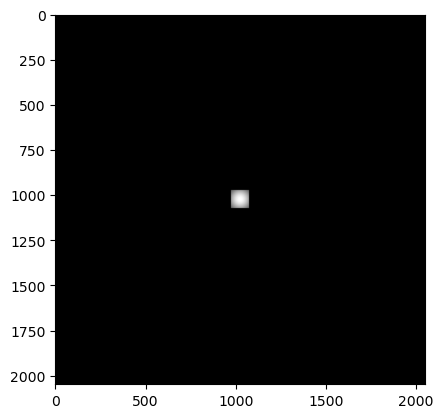

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [112]:
generate_spots(2048, 100, 10000)

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid size
grid_size = 2048

# Define spot size and intensity
spot_size = 100
spot_intensity = 10000

# Define number of spots and width of the spots
num_spots = 1000
spot_width = 100

# Create grid of zeros
grid = np.zeros((grid_size, grid_size))

# Calculate center coordinates
center_x = int(grid_size / 2)
center_y = int(grid_size / 2)

# Generate spots
for i in range(num_spots):
    # Calculate radius of current spot
    radius = i * spot_width
    
    # Generate spot at current radius
    for j in range(center_x - int(radius + spot_size/2), center_x + int(radius + spot_size/2)):
        for k in range(center_y - int(radius + spot_size/2), center_y + int(radius + spot_size/2)):
            distance = np.sqrt((j - center_x)**2 + (k - center_y)**2)
            if distance <= radius + spot_size/2 and distance >= radius - spot_size/2:
                intensity = spot_intensity * np.exp(-(distance - radius)**2 / (2 * (spot_size/2)**2))
                grid[j, k] += intensity

# Display grid as image
plt.imshow(grid, cmap='gray')
plt.show()

IndexError: index 2048 is out of bounds for axis 1 with size 2048

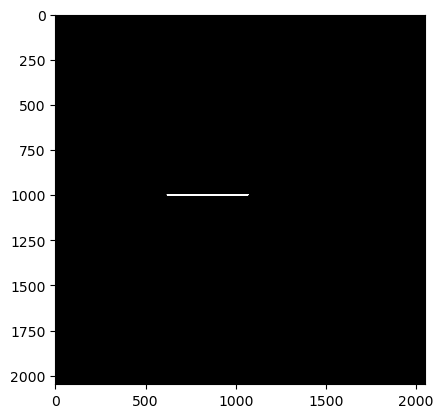

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid size
grid_size = 2048

# Define spot size and intensity
spot_size = 100
spot_intensity = 10000

# Define width between lines of spots
line_width = 40

# Define number of lines of spots
num_lines = 10

# Create grid of zeros
grid = np.zeros((grid_size, grid_size))

# Calculate center coordinates
center_x = int(grid_size / 2)
center_y = int(grid_size / 2)

# Generate spots
for i in range(num_lines):
    # Calculate y-coordinate of current line
    y = center_y - (i * line_width)
    
    # Generate spots on current line
    for j in range(center_x - int(grid_size/2), center_x + int(grid_size/2), spot_size):
        for k in range(y - int(spot_size/2), y + int(spot_size/2)):
            distance = np.sqrt((j - center_x)**2 + (k - y)**2)
            if distance <= spot_size/2:
                intensity = spot_intensity * np.exp(-(distance - spot_size/2)**2 / (2 * (spot_size/2)**2))
                grid[j, k] += intensity

# Display grid as image
plt.imshow(grid, cmap='gray', vmin = 0, vmax = 100)
plt.show()

In [126]:
  def create_anisotropic(nspots, width, offset, size=4, shape = 'square', cmap = 'viridis'):
    """
    This function generates a 2D image of small spots on a detector image that's 2048x2048 pixels. Each spot is separated by a width and offset and has the highest intensity in the center of the spot and the 
    lowest intensity at the edges of the spot. The spots are 4x4 pixels in size. The function should take the number of spots, the width of the spots, and the offset between spots as parameters.

    Parameters:
        nspots (int): The number of spots to generate.
        width (float): The width of the spots.
        offset (float): The offset between spots.
    """
    # initialize the detector image
    detector_image = np.zeros((2048, 2048))
    
    #generate the spots, but should start at zero of the grid and then move over by the offset
    
    
            
    
    for i in range(nspots):
        print(i)
        for j in range(nspots):
            if shape == 'square':
                x = i * offset
                y = j * offset
                for k in range(size):
                    for l in range(size):
                        if x + k < 2048 and y + l < 2048:
                            detector_image[x+k][y+l] = np.exp(-((k-size/2)**2 + (l-size/2)**2) / (2 * width**2))
                    
    # display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(detector_image, cmap=cmap)
    plt.title("2D X-Ray Diffraction Image")
    plt.show()
    
    return detector_image

In [125]:
b =  [0, 2, 3]

for i in range(len(b)):
    
    print(i)

0
1
2
